# To someone who inspects this work, please read before run

the model will be trained with 500 epochs which takes about 130-150 seconds, and the hyperparameter search will have 20 iterations, so it takes 40-50 minutes to run the whole notebook. Please review our results before you run it. Thank you!

In [ ]:
!pip install ray
!pip install tensorboardX

In [ ]:
import gdown

url = 'https://drive.google.com/drive/u/1/folders/15s4q-UX-OffTIxU_y0Y06SPYynXQmQxS'

gdown.download_folder(url)

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.model_selection import KFold
import torch
from torch import nn,optim
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
# Grid Search
from functools import partial
import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import ASHAScheduler

We plan to implement 2 deep learning models: the first one is a 3-hidden-layerd MLP with dropout, the other one is a LSTM. After the implementation, we will conduct hyperparameter search with Ray to investigate effects of "Batch size", "optimizers" , "learning rate" ,and other parameters regarding models.

# Data Preprocessing

In [5]:
class LMP_Dataset(torch.utils.data.Dataset):
    def __init__(self, Data, Label):
        self.Data = Data.astype(np.float32)
        if Label.ndim==1:
            self.Label = np.expand_dims(Label, 0).astype(np.float32).reshape(-1,1)
        else:
            self.Label = Label.astype(np.float32).reshape(-1,1)

    def __len__(self):
        return self.Data.shape[0]

    def __getitem__(self, idx):
        data_tensor = torch.tensor(self.Data[idx])
        label_tensor = torch.tensor(self.Label[idx])
        return data_tensor,label_tensor


def prep_data(df,batch_size = 500, shuffle=True):
    # Training : Validation : Testing = 70 : 15 : 15
    feature_train, feature_test, label_train, label_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1], test_size=0.3,shuffle=shuffle, random_state=39)
    feature_vali, feature_test, label_vali, label_test = train_test_split(feature_test,label_test, test_size=0.5,shuffle=shuffle, random_state=39)
    
    train_dataset = LMP_Dataset(feature_train.values, label_train)
    vali_dataset = LMP_Dataset(feature_vali.values,label_vali)
    test_dataset = LMP_Dataset(feature_test.values, label_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=shuffle, drop_last=False)        
    vali_loader = torch.utils.data.DataLoader(vali_dataset, batch_size = batch_size, shuffle=shuffle, drop_last=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=shuffle, drop_last=False)
    return train_loader,vali_loader,test_loader

def prep_data_norm(df,batch_size = 500, shuffle=True):
    # Normalization
    feature_scaler = preprocessing.MinMaxScaler()
    label_scaler = preprocessing.MinMaxScaler()
    feature = df.iloc[:,:-1]
    label = df.iloc[:,-1]
    feature_scaled = feature_scaler.fit_transform(feature)
    label_scaled = label_scaler.fit_transform(np.expand_dims(label,axis=1))
    # Training : Validation : Testing = 70 : 15 : 15
    feature_train, feature_test, label_train, label_test = train_test_split(feature_scaled,label_scaled, test_size=0.3,shuffle=shuffle, random_state=39)
    feature_vali, feature_test, label_vali, label_test = train_test_split(feature_test,label_test, test_size=0.5,shuffle=shuffle, random_state=39)
    
    train_dataset = LMP_Dataset(feature_train, label_train)
    vali_dataset = LMP_Dataset(feature_vali,label_vali)
    test_dataset = LMP_Dataset(feature_test, label_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=shuffle, drop_last=False)        
    vali_loader = torch.utils.data.DataLoader(vali_dataset, batch_size = batch_size, shuffle=shuffle, drop_last=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=shuffle, drop_last=False)
    return train_loader,vali_loader,test_loader, label_scaler


In [10]:
class Three_hiddenLayerd_MLP_dropout(torch.nn.Module):
    def __init__(self,hidden_1,hidden_2,hidden_3,dropout):
        super().__init__()
        self.input_size = 32
        self.output_size = 1

        self.linear_1 = torch.nn.Sequential(
            torch.nn.Linear(self.input_size,hidden_1),
            torch.nn.ReLU())
        self.linear_2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_1,hidden_2),
            torch.nn.ReLU())
        self.linear_3 = torch.nn.Sequential(
            torch.nn.Linear(hidden_2,hidden_3),
            torch.nn.ReLU(), 
            torch.nn.Dropout(dropout))
        self.linear_4 = torch.nn.Sequential(
            torch.nn.Linear(hidden_3,self.output_size))

    def forward(self,x):
        out = self.linear_1(x)
        out = self.linear_2(out)
        out = self.linear_3(out)
        out = self.linear_4(out)
        return out

    def reset_weights(self):
        self.linear_1.reset_parameters()
        self.linear_2.reset_parameters()
        self.linear_3.reset_parameters()
        self.linear_4.reset_parameters()



# Train

In [19]:
def train_with_ray(config):
  # Load data and model configurations
  hidden_1,hidden_2,hidden_3,dropout,optimizer_name,lr,batch_size = config
  os.chdir('/content')
  df = pd.read_csv('dat/data_full_clean.csv')
  train_loader,vali_loader,_,_ = prep_data_norm(df)

  model = Three_hiddenLayerd_MLP_dropout(config["hidden_1"],config["hidden_2"],config["hidden_3"],config["dropout"])
  device = "cpu"
  if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
          model = nn.DataParallel(model)
  model.to(device)

  mse_loss = torch.nn.MSELoss()
  criterion = lambda x, y: mse_loss(x, y)
  if config["optimizer_name"] == "SGD":
      optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)
  else:
      optimizer = optim.Adam(model.parameters(), lr=config["lr"])

  # To restore a checkpoint, use `session.get_checkpoint()`.
  loaded_checkpoint = session.get_checkpoint()
  if loaded_checkpoint:
      with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
          model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
      model.load_state_dict(model_state)
      optimizer.load_state_dict(optimizer_state)
  # Total epochs number is set to 500.
  epochs = 500
  train_losses=[]
  vali_losses=[]
  for epoch in range(epochs):
    train_epoch_loss = 0
    vali_epoch_loss=0
    # Training
    model.train()
    for batch_feature, batch_label in train_loader:
        optimizer.zero_grad()
        prediction = model(batch_feature)
        loss = criterion(prediction, batch_label)
        if epoch>0:
            loss.backward()
            optimizer.step()
        train_epoch_loss += loss.item()
    train_losses.append(train_epoch_loss/len(train_loader))
    # Validation
    model.eval()
    with torch.no_grad():
        for batch_feature, batch_label in vali_loader:
            prediction = model(batch_feature)
            loss = criterion(prediction, batch_label)
            vali_epoch_loss += loss.item()
        vali_losses.append(vali_epoch_loss/len(vali_loader))
    # Save checkpoints
    os.makedirs("mlp_model", exist_ok=True)
    torch.save((model.state_dict(), optimizer.state_dict()), "mlp_model/checkpoint.pt")
    checkpoint = Checkpoint.from_directory("mlp_model")
  session.report({"loss": vali_epoch_loss/len(vali_loader)}, checkpoint=checkpoint)
  print("Finished Training")

def test_best_model(best_result):

  best_trained_model = Three_hiddenLayerd_MLP_dropout(best_result.config["hidden_1"],best_result.config["hidden_2"],best_result.config["hidden_3"],best_result.config["dropout"])
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  best_trained_model.to(device)

  checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

  model_state, optimizer_state = torch.load(checkpoint_path)
  best_trained_model.load_state_dict(model_state)

  mse_loss = torch.nn.MSELoss()
  criterion = lambda x, y: mse_loss(x, y)

  os.chdir('/content')
  df = pd.read_csv('dat/data_full_clean.csv')
  train_loader,vali_loader,test_loader = prep_data(df)

  epoch_loss=0
  predictions=[]
  for feature,label in test_loader:
    prediction = best_trained_model(feature)
    loss = criterion(prediction, label)
    epoch_loss += loss.item()
    predictions.extend(prediction.squeeze().detach().numpy())

  print("Best trial test set loss: {}".format(epoch_loss/len(test_loader)))

  rcParams['figure.figsize'] = 10,8
  plt.plot(test_loader.dataset.Label,label='Ground Truth')
  plt.plot(predictions,label="Predication")
  plt.title("Prediction on Test set" )
  plt.legend()
  plt.show()

def test_best_model_norm(best_result):
  # Load configuration of model with best performance
  best_trained_model = Three_hiddenLayerd_MLP_dropout(
      best_result.config["hidden_1"],
      best_result.config["hidden_2"],
      best_result.config["hidden_3"],
      best_result.config["dropout"])
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  best_trained_model.to(device)

  checkpoint_path = os.path.join(
      best_result.checkpoint.to_directory(),
      "checkpoint.pt")

  model_state, optimizer_state = torch.load(checkpoint_path)
  best_trained_model.load_state_dict(model_state)
  # Notice that labels are denormalized, the torch MSE 
  # is not applicable, so the criterion is hard-coded.
  criterion = lambda x, y: ((x-y)**2).mean(axis=0)

  os.chdir('/content')
  df = pd.read_csv('dat/data_full_clean.csv')
  train_loader,vali_loader,test_loader,y_scaler = prep_data_norm(df)

  epoch_loss=0
  predictions=[]
  labels = []
  for feature,label in test_loader:
    prediction = best_trained_model(feature)
    # Denormalize label and prediction 
    # so that the loss is shown with actual MSE.
    label = y_scaler.inverse_transform(label).squeeze()
    prediction = y_scaler.inverse_transform(
        prediction.detach().numpy()).squeeze()
    loss = criterion(prediction, label)
    epoch_loss += loss.item()
    labels.extend(label.squeeze())
    predictions.extend(prediction.squeeze())

  print("Best model actual loss: {}".format(epoch_loss/len(test_loader)))

  rcParams['figure.figsize'] = 10,8
  plt.plot(labels,label='Labels',alpha=.7,color='r')
  plt.plot(predictions,label="Predications",color='blue',alpha=.6)
  plt.title("Prediction on Test set" )
  plt.legend()
  plt.show()


In [20]:
def main(num_samples=3, max_time=100, gpus_per_trial=0 ):
  # Hyperparameter pool
  config = {
      "batch_size": tune.choice([500,1000]),
      "hidden_1": tune.choice([16*i for i in range(1,4)]),
      "hidden_2": tune.choice([16*2*i for i in range(1,4)]),
      "hidden_3": tune.choice([16*i for i in range(1,4)]),
      "dropout": tune.choice([0,0.1,0.2]),
      "optimizer_name": tune.choice(["SGD","ADAM"]),
      "lr": tune.choice([10**(-i) for i in range(1,5)])
  }
  scheduler = ASHAScheduler(
      max_t=max_time,
      grace_period=1,
      reduction_factor=2)
  
  tuner = tune.Tuner(
      tune.with_resources(
          tune.with_parameters(train_with_ray),
          resources={"cpu": 2, "gpu": gpus_per_trial}
      ),
      tune_config=tune.TuneConfig(
          metric="loss",
          mode="min",
          scheduler=scheduler,
          num_samples=num_samples,
      ),
      param_space=config
  )
  results = tuner.fit()
  
  best_result = results.get_best_result("loss", "min")

  print("Best trial config: {}".format(best_result.config))
  print("Best trial final validation loss: {}".format(
      best_result.metrics["loss"]))

  return best_result
    
best_result=main(num_samples=20, max_time=300, gpus_per_trial=0)

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_with_ray_7c5c2_00000,2022-11-29_19-41-23,True,,1b093e8bc20e4e5a96acbcdeef18cb6b,85b0f1b886ba,1,0.000154243,172.28.0.2,1318,True,132.067,132.067,132.067,1669750883,0,,1,7c5c2_00000,0.00736928
train_with_ray_7c5c2_00001,2022-11-29_19-43-36,True,,1b093e8bc20e4e5a96acbcdeef18cb6b,85b0f1b886ba,1,0.00132326,172.28.0.2,1318,True,132.471,132.471,132.471,1669751016,0,,1,7c5c2_00001,0.00736928
train_with_ray_7c5c2_00002,2022-11-29_19-45-38,True,,1b093e8bc20e4e5a96acbcdeef18cb6b,85b0f1b886ba,1,0.000183435,172.28.0.2,1318,True,121.808,121.808,121.808,1669751138,0,,1,7c5c2_00002,0.00736928
train_with_ray_7c5c2_00003,2022-11-29_19-47-58,True,,1b093e8bc20e4e5a96acbcdeef18cb6b,85b0f1b886ba,1,0.000174877,172.28.0.2,1318,True,140,140,140,1669751278,0,,1,7c5c2_00003,0.00736928
train_with_ray_7c5c2_00004,2022-11-29_19-50-11,True,,1b093e8bc20e4e5a96acbcdeef18cb6b,85b0f1b886ba,1,0.000147516,172.28.0.2,1318,True,133.461,133.461,133.461,1669751411,0,,1,7c5c2_00004,0.00736928
train_with_ray_7c5c2_00005,2022-11-29_19-52-18,True,,1b093e8bc20e4e5a96acbcdeef18cb6b,85b0f1b886ba,1,0.00134288,172.28.0.2,1318,True,126.981,126.981,126.981,1669751538,0,,1,7c5c2_00005,0.00736928
train_with_ray_7c5c2_00006,2022-11-29_19-54-05,True,,1b093e8bc20e4e5a96acbcdeef18cb6b,85b0f1b886ba,1,0.000665565,172.28.0.2,1318,True,106.194,106.194,106.194,1669751645,0,,1,7c5c2_00006,0.00736928
train_with_ray_7c5c2_00007,2022-11-29_19-55-53,True,,1b093e8bc20e4e5a96acbcdeef18cb6b,85b0f1b886ba,1,0.00017701,172.28.0.2,1318,True,108.679,108.679,108.679,1669751753,0,,1,7c5c2_00007,0.00736928
train_with_ray_7c5c2_00008,2022-11-29_19-58-01,True,,1b093e8bc20e4e5a96acbcdeef18cb6b,85b0f1b886ba,1,0.000171584,172.28.0.2,1318,True,127.128,127.128,127.128,1669751881,0,,1,7c5c2_00008,0.00736928
train_with_ray_7c5c2_00009,2022-11-29_20-00-05,True,,1b093e8bc20e4e5a96acbcdeef18cb6b,85b0f1b886ba,1,0.00128875,172.28.0.2,1318,True,124.188,124.188,124.188,1669752005,0,,1,7c5c2_00009,0.00736928


(train_with_ray pid=1318) Finished Training
(train_with_ray pid=1318) Finished Training
(train_with_ray pid=1318) Finished Training
(train_with_ray pid=1318) Finished Training
(train_with_ray pid=1318) Finished Training
(train_with_ray pid=1318) Finished Training
(train_with_ray pid=1318) Finished Training
(train_with_ray pid=1318) Finished Training
(train_with_ray pid=1318) Finished Training
(train_with_ray pid=1318) Finished Training


2022-11-29 20:18:07,522	INFO tune.py:778 -- Total run time: 2341.42 seconds (2341.26 seconds for the tuning loop).


Best trial config: {'batch_size': 1000, 'hidden_1': 48, 'hidden_2': 64, 'hidden_3': 32, 'dropout': 0.1, 'optimizer_name': 'ADAM', 'lr': 0.01}
Best trial final validation loss: 0.00013324373139766976


## Report
1. Optimizer: From the report, we can see that models with SGD converges faster than models with ADAM in general, but the best result is generated by model with ADAM.

2. Batch Size: It has been observed that when using a batch size of 1000, the loss is generally larger than the model with batch size of 500. We consider that it is due to the degradation in ability to genralize. Large-batch methods tend to converge to sharp minimizers of the training function.   

3. Other Hyperparameters: The best result occurs on the model with relatively large numbers of perceptrons in hidden layers. The dropout rate is small since dropout is usually used on image projects and seldomly used on plain numerical data. The learning rate is 1e-2, which is not so large.


# Test

Best trial test set actual loss: 206.11089083907467


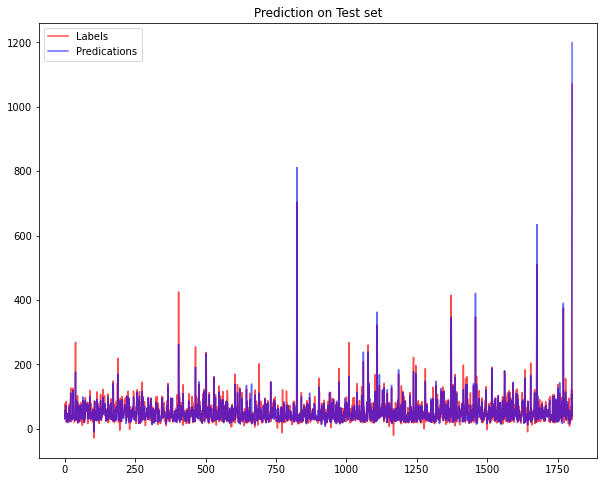

In [21]:
test_best_model_norm(best_result)

The loss is 27.7% lower than the benchmark 285.

Please follow this link to reach the other model: https://drive.google.com/file/d/1CoBevmEOxcMvFUVEtSsHQYCJu7tHjY92/view?usp=sharing